In [3]:
from dataset import *

from config import config as cfg

cfg.DATA.batch_size = 2

dm = MotionDataModule(cfg.DATA)
dm.setup()

2965
192
588


In [4]:
batch = next(iter(dm.train_dataloader()))
pose0,  velocity_relative, root_travel = batch

ValueError: too many values to unpack (expected 3)

In [5]:
[(b.shape, b.dtype) for b in batch]

[(torch.Size([2, 1, 22, 3]), torch.float32),
 (torch.Size([2, 159, 22, 3]), torch.float32),
 (torch.Size([2, 160, 1, 3]), torch.float32),
 (torch.Size([2, 160, 22, 3]), torch.float32),
 (torch.Size([2, 160, 22, 3]), torch.float32)]

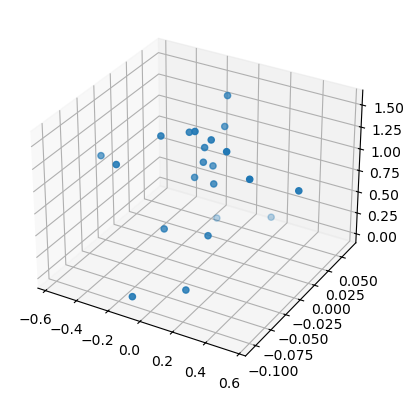

In [ ]:
import matplotlib.pyplot as plt
# 3d
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pose0[0, 0, :, 0], pose0[0, 0, :, 2], pose0[0, 0, :, 1], 'r')

torch.Size([2, 160, 22, 3])
torch.Size([2, 160, 1, 3])


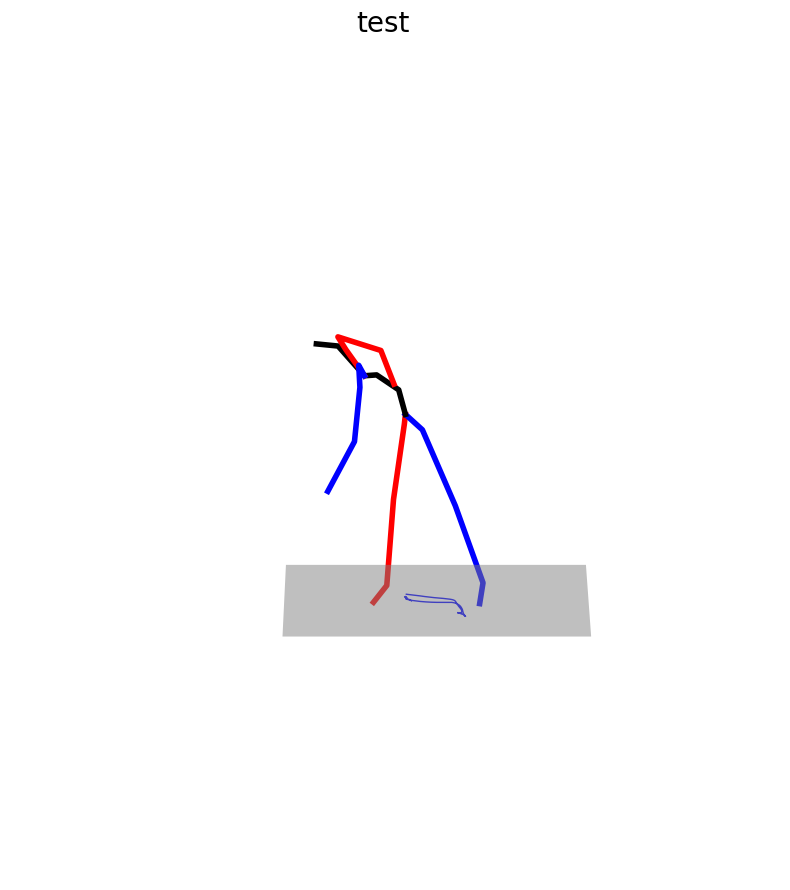

In [ ]:
# reconstruction from pose0,  velocity_relative, root_travel
import torch
pose0,  velocity_relative, root_travel = batch
motion_less_root = torch.cumsum(torch.cat([pose0, velocity_relative], dim=1), dim=1)
print(motion_less_root.shape)
print(root_travel.shape)
# root_travel-=root_travel[:,:1,:,:]
motion = motion_less_root + root_travel
# print(motion.shape)
# pos_rel = np.cumsum(np.concatenate([pose0, velocity_relative ], axis=1), axis=1)

# print(pos_rel.shape, root_travel.shape, type(pos_rel), type(root_travel))
# pos = pos_rel# + root_travel.numpy()[:, None, :]

from utils import plot_3d_motion_animation
plot_3d_motion_animation(motion[0].numpy(), title='test', figsize=(10, 10), fps=20, radius=2, save_path='test123.mp4', velocity=False)


In [6]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from utils import plot_3d_motion_frames_multiple, plot_3d_motion_animation, plot_3d_motion_frames_multiple
from glob import glob
import matplotlib.pyplot as plt


activation_dict = {
    'tanh': nn.Tanh(),
    'leaky_relu': nn.LeakyReLU(),
    'relu': nn.ReLU(),
    'sigmoid': nn.Sigmoid(),
    'elu': nn.ELU(),
    'swish': nn.SiLU(),
    'mish': nn.Mish(),
    'softplus': nn.Softplus(),
    'softsign': nn.Softsign(),
    # 'bent_identity': nn.BentIdentity(),
    # 'gaussian': nn.Gaussian(),
    'softmax': nn.Softmax(),
    'softmin': nn.Softmin(),
    'softshrink': nn.Softshrink(),
    # 'sinc': nn.Sinc(),
}


class CustomLoss(nn.Module):
    def __init__(self, klDiv_weight=0.000002, relative_weight=1,  root_weight=1):
        super(CustomLoss, self).__init__()
        self.klDiv_weight = klDiv_weight

    
    def forward(self, rel_rec, rel, root_rec, root, mu, logvar):
        mse_rel = F.mse_loss(rel_rec, rel)
        mse_root = F.mse_loss(root_rec, root)
        klDiv = self.kl_divergence(mu, logvar)

        loss = {
            'mse_rel': mse_rel,
            'mse_root': mse_root,
            'klDiv': klDiv,
            'total': mse_rel + mse_root + self.klDiv_weight * klDiv
        }
        return loss
    
    
    def kl_divergence(self, mu, logvar):
        return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    

# no activation class
class Identity(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x
    
class TransformerMotionAutoencoder_Chunked(nn.Module):
    """
    We want this class to recieve:
        pose0: (batch_size, 1, num_joints=22, 3)
        velocity_relative: (batch_size, seq_len-1, num_joints=22, 3)
        root_travel: (batch_size, seq_len, 1, 3)
    from the dataloader and output:
        the same pose0,  velocity_relative, root_travel
    """
    def __init__(
        self,
        cfg,

    ):
        super(TransformerMotionAutoencoder_Chunked, self).__init__()

        # data things
        self.seq_len = cfg.get("seq_len", 160)
        self.input_dim = cfg.get("input_dim", 66)
        
        # model things
        self.hidden_dim = cfg.get("hidden_dim", 1024)
        self.n_layers = cfg.get("n_layers", 8)
        self.n_heads = cfg.get("n_heads", 6)
        self.dropout = cfg.get("dropout", 0.10)
        self.latent_dim = cfg.get("latent_dim", 256)
        self.activation = cfg.get("activation", "relu")
        self.activation = activation_dict[self.activation]
        self.transformer_activation = cfg.get("transformer_activation", "gelu")
        self.output_layer = cfg.get("output_layer", "linear")
        self.clip = cfg.get("clip_grad_norm", 1)
        self.batch_norm = cfg.get("batch_norm", False)
        self.hindden_encoder_layer_widths = cfg.get("hidden_encoder_layer_widths", [256] * 3 )

        # training things
        self.lr = cfg.get("learning_rate", 1 * 1e-5)
        self.optimizer = cfg.get("optimizer", "AdamW")
        self.load = cfg.get("load", False)
        self.checkpoint_path = cfg.get("_checkpoint_path", None)

        # logging things
        self.save_animations = cfg.get("_save_animations", True)
        self.loss_function = CustomLoss(cfg.get("klDiv_weight", 0.000001))


        ##### MODEL #####
        # the strucure will be as follows:
        # 0. con
        ## 1. encoder
            ## chunked transformer
            ## concat
            ## linear layer
        ## reparameterize
        ## 2. decoder
            ## linear layer
            ## chunked transformer
            ## concat
        
        # vel transformer encoder
        cfg_vte = cfg.MODEL.vel_transformer_encoder
        self.vel_transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=66,
                nhead=cfg_vte.get("nhead", 6),
                dim_feedforward=cfg_vte.get("dim_feedforward", 1024),
                dropout=cfg_vte.get("dropout", 0.1),
                activation=cfg_vte.get("activation", "relu"),
            ),
            num_layers=cfg_vte.get("num_layers", 6),
        ) 

        # root transformer encoder
        cfg_rte = cfg.MODEL.root_travel_transformer_encoder
        self.root_travel_transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=3,
                nhead=cfg_rte.get("nhead", 3),
                dim_feedforward=cfg_rte.get("dim_feedforward", 512),
                dropout=cfg_rte.get("dropout", 0.1),
                activation=cfg_rte.get("activation", "relu"),
            ),
            num_layers=cfg_rte.get("num_layers", 6),
        )
        
        # linear encoder
        cfg_le = cfg.MODEL.linear_encoder
        self.linear_encoder = nn.Sequential()
        current_dim = (self.seq_len -1 ) * 66 + 3 * self.seq_len + 66
        in_dims = [current_dim] + cfg_le.get("hidden_encoder_layer_widths", [256] * 3)
        out_dims = cfg_le.get("hidden_encoder_layer_widths", [256] * 3) + [2 * self.latent_dim]
        for i, (in_dim, out_dim) in enumerate(zip(in_dims, out_dims)):
            self.linear_encoder.add_module(f"linear_{i}", nn.Linear(in_dim, out_dim))
            if i< len(in_dims) - 1:
                self.linear_encoder.add_module(f"activation_{i}", activation_dict[cfg_le.get("activation", "relu")])
                if self.batch_norm:
                    self.linear_encoder.add_module(f"batch_norm_{i}", nn.BatchNorm1d(out_dim))
                self.linear_encoder.add_module(f"dropout_{i}", nn.Dropout(cfg_le.get("dropout", 0.1)))


        # linear decoder
        cfg_ld = cfg.MODEL.linear_decoder
        self.linear_decoder = nn.Sequential()
        target_dim = current_dim
        current_dim = self.latent_dim
        in_dims = [current_dim] + cfg_ld.get("hidden_decoder_layer_widths", [256] * 3)
        out_dims = cfg_ld.get("hidden_decoder_layer_widths", [256] * 3) + [target_dim]
        for i, (in_dim, out_dim) in enumerate(zip(in_dims, out_dims)):
            self.linear_decoder.add_module(f"linear_{i}", nn.Linear(in_dim, out_dim))
            # if i>0:
            self.linear_decoder.add_module(f"activation_{i}", activation_dict[cfg_ld.get("activation", "relu")])
            if self.batch_norm:
                self.linear_decoder.add_module(f"batch_norm_{i}", nn.BatchNorm1d(out_dim))
            self.linear_decoder.add_module(f"dropout_{i}", nn.Dropout(cfg_ld.get("dropout", 0.1)))

        # vel transformer decoder
        cfg_vtd = cfg.MODEL.vel_transformer_decoder
        self.vel_transformer_decoder = nn.TransformerDecoder(
            nn.TransformerDecoderLayer(
                d_model=66,
                nhead=cfg_vtd.get("nhead", 6),
                dim_feedforward=cfg_vtd.get("dim_feedforward", 1024),
                dropout=cfg_vtd.get("dropout", 0.1),
                activation=cfg_vtd.get("activation", "relu"),
            ),
            num_layers=cfg_vtd.get("num_layers", 6),
        )
    
        # root transformer decoder
        cfg_rtd = cfg.MODEL.root_travel_transformer_decoder
        self.root_travel_transformer_decoder = nn.TransformerDecoder(
            nn.TransformerDecoderLayer(
                d_model=3,
                nhead=cfg_rtd.get("nhead", 3),
                dim_feedforward=cfg_rtd.get("dim_feedforward", 512),
                dropout=cfg_rtd.get("dropout", 0.1),
                activation=cfg_rtd.get("activation", "relu"),
            ),
            num_layers=cfg_rtd.get("num_layers", 6),
        )
    
    

    def encode(self, pose0,  velocity_relative, root_travel):
        # pose0: (batch_size, 1, num_joints=22, 3)
        # velocity_relative: (batch_size, seq_len-1, num_joints=22, 3)
        # root_travel: (batch_size, seq_len, 1, 3)

        # 1. encoder
        # chunked transformer for vel and roof
        # concat
        # linear layer
        pose0 = pose0.view(-1, 66)
        velocity_relative = velocity_relative.view(-1, self.seq_len-1, 66)
        root_travel = root_travel.view(-1, self.seq_len, 3)

        # vel
        vel = self.vel_transformer_encoder(velocity_relative,)
        # root
        root = self.root_travel_transformer_encoder(root_travel, )

        print('vel:', vel.shape)
        print('root:', root.shape)
        print('pose0:', pose0.shape)
        # concat
        x = torch.cat([nn.Flatten()(vel), nn.Flatten()(root), pose0], dim=1)
        x = self.linear_encoder(x)
        mu, logvar = torch.chunk(x, 2, dim=1)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu.__add__(eps.__mul__(std))
    
    def decode(self, z):
        # linear layer
        # chunked transformer
        # concat
        z = self.linear_decoder(z)
        # vel
        print(z.shape)
        pose0 = z[:, -66:].view(-1, 1, 22, 3)
        vel = z[:, :(self.seq_len-1) * 66].view(-1, self.seq_len-1, 22* 3)
        root = z[:, (self.seq_len-1) * 66:-66].view(-1, self.seq_len, 3)

        vel = self.vel_transformer_decoder(vel, vel)
        root = self.root_travel_transformer_decoder(root, root)

        return pose0, vel, root
    
    def forward(self, pose0,  velocity_relative, root_travel):
        mu, logvar = self.encode(pose0,  velocity_relative, root_travel)
        z = self.reparameterize(mu, logvar)
        pose0_rec, vel_rec, root_rec = self.decode(z)
        
        return pose0_rec, vel_rec, root_rec, mu, logvar
    
    
class TransformerMotionAutoencoder_Concatenated(nn.Module):
    """
    We want this class to recieve:
        pose0: (batch_size, 1, num_joints=22, 3)
        velocity_relative: (batch_size, seq_len-1, num_joints=22, 3)
        root_travel: (batch_size, seq_len, 1, 3)
    from the dataloader and output:
        the same pose0,  velocity_relative, root_travel
    """
    def __init__(
        self,
        cfg,

    ):
        super(TransformerMotionAutoencoder_Concatenated, self).__init__()

        # data things
        self.seq_len = cfg.get("seq_len", 160)
        self.input_dim = cfg.get("input_dim", 66)
        
        # model things
        self.hidden_dim = cfg.get("hidden_dim", 1024)
        self.n_layers = cfg.get("n_layers", 8)
        self.n_heads = cfg.get("n_heads", 6)
        self.dropout = cfg.get("dropout", 0.10)
        self.latent_dim = cfg.get("latent_dim", 256)
        self.activation = cfg.get("activation", "relu")
        self.activation = activation_dict[self.activation]
        self.transformer_activation = cfg.get("transformer_activation", "gelu")
        self.output_layer = cfg.get("output_layer", "linear")
        self.clip = cfg.get("clip_grad_norm", 1)
        self.batch_norm = cfg.get("batch_norm", False)
        self.hindden_encoder_layer_widths = cfg.get("hidden_encoder_layer_widths", [256] * 3 )

        # training things
        self.lr = cfg.get("learning_rate", 1 * 1e-5)
        self.optimizer = cfg.get("optimizer", "AdamW")
        self.load = cfg.get("load", False)
        self.checkpoint_path = cfg.get("_checkpoint_path", None)

        # logging things
        self.save_animations = cfg.get("_save_animations", True)
        self.loss_function = CustomLoss(cfg.get("klDiv_weight", 0.000001))


        ##### MODEL #####
        # the strucure will be as follows:
        # 0. concat
        ## 1. encoder
            ## linear
            ##  transformer
            ## flatten
            ## linear layer
        ## reparameterize
        ## 2. decoder
            ## linear layer
            ## chunked transformer
            ## concat

        cfg_lei = cfg.MODEL.CONCAT_TRANSFORMER.linear_encoder_input
        print(cfg_lei)
        self.linear_encoder_input = nn.Sequential()
        current_dim = (self.seq_len -1 ) * 66 + 3 * self.seq_len + 66
        in_dims = [current_dim] + cfg_lei.get("hidden_encoder_layer_widths", [256] * 3)
        out_dims = cfg_lei.get("hidden_encoder_layer_widths", [256] * 3) + [self.seq_len*cfg_lei.get("out_dim", 128)]
        for i, (in_dim, out_dim) in enumerate(zip(in_dims, out_dims)):
            self.linear_encoder_input.add_module(f"linear_{i}", nn.Linear(in_dim, out_dim))
            self.linear_encoder_input.add_module(f"activation_{i}", activation_dict[cfg_lei.get("activation", "relu")])
            if self.batch_norm:
                self.linear_encoder_input.add_module(f"batch_norm_{i}", nn.BatchNorm1d(out_dim))
            self.linear_encoder_input.add_module(f"dropout_{i}", nn.Dropout(cfg_lei.get("dropout", 0.1)))


        # transformer encoder
        cfg_te = cfg.MODEL.CONCAT_TRANSFORMER.transformer_encoder
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=cfg_lei.get("out_dim", 128),
                nhead=cfg_te.get("nhead", 8),
                dim_feedforward=cfg_te.get("dim_feedforward", 1024),
                dropout=cfg_te.get("dropout", 0.1),
                activation=cfg_te.get("activation", "relu"),
            ),
            num_layers=cfg_te.get("num_layers", 6),
        ) 
        # linear encoder
        cfg_le = cfg.MODEL.CONCAT_TRANSFORMER.linear_encoder_output
        self.linear_encoder = nn.Sequential()
        current_dim = self.seq_len * cfg_lei.get("out_dim", 128)
        in_dims = [current_dim] + cfg_le.get("hidden_encoder_layer_widths", [256] * 3)
        out_dims = cfg_le.get("hidden_encoder_layer_widths", [256] * 3) + [2 * self.latent_dim]
        for i, (in_dim, out_dim) in enumerate(zip(in_dims, out_dims)):
            self.linear_encoder.add_module(f"linear_{i}", nn.Linear(in_dim, out_dim))
            if i< len(in_dims) - 1:
                self.linear_encoder.add_module(f"activation_{i}", activation_dict[cfg_le.get("activation", "relu")])
                if self.batch_norm:
                    self.linear_encoder.add_module(f"batch_norm_{i}", nn.BatchNorm1d(out_dim))
                self.linear_encoder.add_module(f"dropout_{i}", nn.Dropout(cfg_le.get("dropout", 0.1)))


        # linear decoder
        cfg_ldi = cfg.MODEL.CONCAT_TRANSFORMER.linear_decoder_input
        self.linear_decoder_input = nn.Sequential()
        target_dim = current_dim
        current_dim = self.latent_dim
        in_dims = [current_dim] + cfg_ldi.get("hidden_decoder_layer_widths", [256] * 3)
        out_dims = cfg_ldi.get("hidden_decoder_layer_widths", [256] * 3) + [target_dim]
        for i, (in_dim, out_dim) in enumerate(zip(in_dims, out_dims)):
            self.linear_decoder_input.add_module(f"linear_{i}", nn.Linear(in_dim, out_dim))
            # if i>0:
            self.linear_decoder_input.add_module(f"activation_{i}", activation_dict[cfg_ldi.get("activation", "relu")])
            if self.batch_norm:
                self.linear_decoder_input.add_module(f"batch_norm_{i}", nn.BatchNorm1d(out_dim))
            self.linear_decoder_input.add_module(f"dropout_{i}", nn.Dropout(cfg_ldi.get("dropout", 0.1)))

        # transformer decoder
        cfg_td = cfg.MODEL.CONCAT_TRANSFORMER.transformer_decoder
        self.transformer_decoder = nn.TransformerDecoder(
            nn.TransformerDecoderLayer(
                d_model=cfg_lei.get("out_dim", 128),
                nhead=cfg_td.get("nhead", 8),
                dim_feedforward=cfg_td.get("dim_feedforward", 1024),
                dropout=cfg_td.get("dropout", 0.1),
                activation=cfg_td.get("activation", "relu"),
            ),
            num_layers=cfg_td.get("num_layers", 6),
        )

        # linear output
        cfg_ldo = cfg.MODEL.CONCAT_TRANSFORMER.linear_decoder_output
        self.linear_decoder_output = nn.Sequential()
        target_dim = (self.seq_len -1 ) * 66 + 3 * self.seq_len + 66
        current_dim = cfg_ldi.get("out_dim", 128) * self.seq_len
        in_dims = [current_dim] + cfg_ldo.get("hidden_decoder_layer_widths", [256] * 3)
        out_dims = cfg_ldo.get("hidden_decoder_layer_widths", [256] * 3) + [target_dim]

        for i, (in_dim, out_dim) in enumerate(zip(in_dims, out_dims)):
            self.linear_decoder_output.add_module(f"linear_{i}", nn.Linear(in_dim, out_dim))
            # if i>0:
            self.linear_decoder_output.add_module(f"activation_{i}", activation_dict[cfg_ldo.get("activation", "relu")])
            if self.batch_norm:
                self.linear_decoder_output.add_module(f"batch_norm_{i}", nn.BatchNorm1d(out_dim))
            self.linear_decoder_output.add_module(f"dropout_{i}", nn.Dropout(cfg_ldo.get("dropout", 0.1)))




    def encode(self, pose0,  velocity_relative, root_travel):
        # pose0: (batch_size, 1, num_joints=22, 3)
        # velocity_relative: (batch_size, seq_len-1, num_joints=22, 3)
        # root_travel: (batch_size, seq_len, 1, 3)

        # 1. encoder
        # concat
        # linear layer
        # transformer encoder

        x = torch.cat([nn.Flatten()(velocity_relative), nn.Flatten()(root_travel), nn.Flatten()(pose0)], dim=1)
        print(x.shape)
        x = self.linear_encoder_input(x)
        x = x.view(-1, self.seq_len, cfg.MODEL.CONCAT_TRANSFORMER.linear_encoder_input.get("out_dim", 128))
        print(x.shape)
        x = self.transformer_encoder(x)
        print(x.shape)
        x = x.view(-1, self.seq_len * cfg.MODEL.CONCAT_TRANSFORMER.linear_encoder_input.get("out_dim", 128))
        print(x.shape)
        x = self.linear_encoder(x)
        mu, logvar = torch.chunk(x, 2, dim=1)
        print(mu.shape, logvar.shape)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu.__add__(eps.__mul__(std))
    
    def decode(self, z):
        out_dim =  cfg.MODEL.CONCAT_TRANSFORMER.linear_encoder_input.get("out_dim", 128)
        print('z shape:     ', z.shape)

        z = self.linear_decoder_input(z)
        print('z shape:     ', z.shape)
        z = z.view(-1, self.seq_len, out_dim)
        print('z shape:     ', z.shape)

        z = self.transformer_decoder(z, z)
        print('z shape:     ', z.shape)
        z = z.view(-1, self.seq_len * out_dim)
        print('z shape:     ', z.shape)
        z = self.linear_decoder_output(z)
        # vel
        print(z.shape)
        pose0 = z[:, -66:].view(-1, 1, 22, 3)
        vel = z[:, :(self.seq_len-1) * 66].view(-1, self.seq_len-1, 22, 3)
        root = z[:, (self.seq_len-1) * 66:-66].view(-1, self.seq_len, 1,  3)


        return pose0, vel, root
    
    def forward(self, pose0,  velocity_relative, root_travel):
        mu, logvar = self.encode(pose0,  velocity_relative, root_travel)
        z = self.reparameterize(mu, logvar)
        pose0_rec, vel_rec, root_rec = self.decode(z)
        relative_motion = self.reconstruct(pose0_rec, vel_rec)
        return relative_motion, root_rec, mu, logvar

    def reconstruct(self, pose0,  velocity_relative):
        motion_less_root = torch.cumsum(torch.cat([pose0, velocity_relative], dim=1), dim=1)
        return motion_less_root
            

# try it out on batch
def reconstruct(pose0,  velocity_relative):
    motion_less_root = torch.cumsum(torch.cat([pose0, velocity_relative], dim=1), dim=1)
    return motion_less_root
from config import config as cfg # to force reload: del cfg; from config import config as cfg
model = TransformerMotionAutoencoder_Concatenated(cfg)  

pose0,  velocity_relative, root_travel, motion_less_root, motion_seq = batch
rel = reconstruct(pose0,  velocity_relative)
print('pose0:', pose0.shape)
print('velocity_relative:', velocity_relative.shape)
print('root_travel:', root_travel.shape)

rel_rec, root_rec, mu, logvar = model(pose0,  velocity_relative, root_travel)
# get loss
loss = model.loss_function(rel_rec, rel, root_rec, root_travel, mu, logvar)
print(loss)

{'hidden_layer_widths': [256, 256, 256], 'dropout': 0.1, 'activation': 'relu', 'out_dim': 128}
pose0: torch.Size([2, 1, 22, 3])
velocity_relative: torch.Size([2, 159, 22, 3])
root_travel: torch.Size([2, 160, 1, 3])
torch.Size([2, 11040])
torch.Size([2, 160, 128])
torch.Size([2, 160, 128])
torch.Size([2, 20480])
torch.Size([2, 256]) torch.Size([2, 256])
z shape:      torch.Size([2, 256])
z shape:      torch.Size([2, 20480])
z shape:      torch.Size([2, 160, 128])
z shape:      torch.Size([2, 160, 128])
z shape:      torch.Size([2, 20480])
torch.Size([2, 11040])
{'mse_rel': tensor(5.1785, grad_fn=<MseLossBackward0>), 'mse_root': tensor(0.5949, grad_fn=<MseLossBackward0>), 'klDiv': tensor(1.2031, grad_fn=<MulBackward0>), 'total': tensor(5.7735, grad_fn=<AddBackward0>)}


In [7]:
cfg.MODEL.CONCAT_TRANSFORMER.linear_decoder_input

{'hidden_layer_widths': [256, 256, 256], 'dropout': 0.1, 'activation': 'relu'}

In [1]:
import torch
checkpoint_path = '../tb_logs5/TransformerMotionAutoencoder/version_85/checkpoints/epoch=34-step=4515.ckpt'
weights = torch.load(checkpoint_path)

In [16]:
print(len(weights['state_dict'].keys()))
enc_weight_keys = list(weights['state_dict'].keys())[:70]
dec_weight_keys = list(weights['state_dict'].keys())[70:]
for key in dec_weight_keys:
    print(key, weights['state_dict'][key].shape)

170
decoder_linear_block.0.weight torch.Size([1024, 1024])
decoder_linear_block.0.bias torch.Size([1024])
decoder_linear_block.3.weight torch.Size([4096, 1024])
decoder_linear_block.3.bias torch.Size([4096])
decoder_linear_block.6.weight torch.Size([8192, 4096])
decoder_linear_block.6.bias torch.Size([8192])
decoder_linear_block.9.weight torch.Size([10560, 8192])
decoder_linear_block.9.bias torch.Size([10560])
transformer_decoder.layers.0.self_attn.in_proj_weight torch.Size([198, 66])
transformer_decoder.layers.0.self_attn.in_proj_bias torch.Size([198])
transformer_decoder.layers.0.self_attn.out_proj.weight torch.Size([66, 66])
transformer_decoder.layers.0.self_attn.out_proj.bias torch.Size([66])
transformer_decoder.layers.0.multihead_attn.in_proj_weight torch.Size([198, 66])
transformer_decoder.layers.0.multihead_attn.in_proj_bias torch.Size([198])
transformer_decoder.layers.0.multihead_attn.out_proj.weight torch.Size([66, 66])
transformer_decoder.layers.0.multihead_attn.out_proj.bias

In [21]:
import numpy as np
import torch
batch_size = 2
seq = 160
nd = 3
nj = 22
x = np.arange(batch_size * seq * nd * nj).reshape(batch_size, seq, nd * nj)
x = torch.tensor(x).int()

# chunk
print(x.shape)
# number of timesteps per chunk
chunk_size = 10
x = x.view(batch_size, seq//chunk_size, chunk_size, nd * nj)
print(x.shape)



torch.Size([2, 160, 66])
torch.Size([2, 16, 10, 66])


In [19]:
x

tensor([[[[    0,     1,     2,  ...,    63,    64,    65],
          [   66,    67,    68,  ...,   129,   130,   131],
          [  132,   133,   134,  ...,   195,   196,   197],
          ...,
          [  462,   463,   464,  ...,   525,   526,   527],
          [  528,   529,   530,  ...,   591,   592,   593],
          [  594,   595,   596,  ...,   657,   658,   659]],

         [[  660,   661,   662,  ...,   723,   724,   725],
          [  726,   727,   728,  ...,   789,   790,   791],
          [  792,   793,   794,  ...,   855,   856,   857],
          ...,
          [ 1122,  1123,  1124,  ...,  1185,  1186,  1187],
          [ 1188,  1189,  1190,  ...,  1251,  1252,  1253],
          [ 1254,  1255,  1256,  ...,  1317,  1318,  1319]],

         [[ 1320,  1321,  1322,  ...,  1383,  1384,  1385],
          [ 1386,  1387,  1388,  ...,  1449,  1450,  1451],
          [ 1452,  1453,  1454,  ...,  1515,  1516,  1517],
          ...,
          [ 1782,  1783,  1784,  ...,  1845,  1846,